In [5]:
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from tqdm import tqdm

In [2]:
base_dir = '/media/sergey/Transcend/Serega/maga_diplom/common/new_images/'
pic_data_dir = os.path.join(base_dir, 'images')
text_data_dir = os.path.join(base_dir, 'text')


img_width, img_height = 224, 224  # Default input size for VGG16

In [ ]:
base_dir = '/media/sergey/Transcend/Serega/maga_diplom/common/new_images_v2/'
pic_data_dir = os.path.join(base_dir, 'one_pict_sign')
some_pic_data_dir = os.path.join(base_dir, 'some_picts')
text_color_data_dir = os.path.join(base_dir, 'text_color_dark_backgr')
text_img


img_width, img_height = 224, 224  # Default input size for VGG16

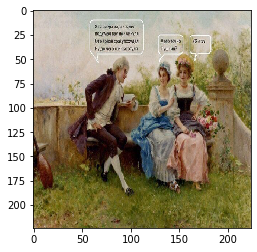

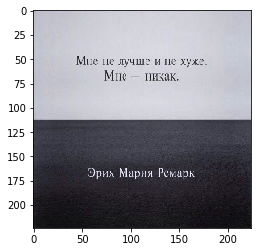

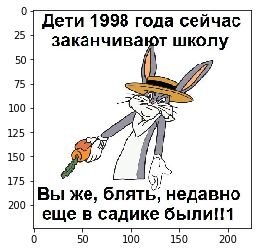

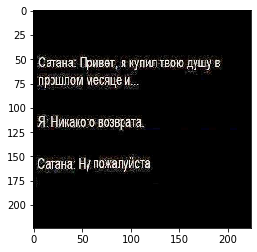

In [3]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(pic_data_dir)
    show_pictures(text_data_dir)

In [ ]:
from tensorflow.keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet', 
                  include_top=False,
                  input_shape=(224, 224, 3))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 2cb95161c43110f7111970584f804107 so we will re-download the data.
102981632/102967424 [==============================] - 9s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, train_sample_count, valid_sample_count):
    train_features = np.zeros(shape=(train_sample_count, 7, 7, 2048))  # Must be equal to the output of the convolutional base
    train_labels = np.zeros(shape=(train_sample_count))
    
    valid_features = np.zeros(shape=(valid_sample_count, 7, 7, 2048))  # Must be equal to the output of the convolutional base
    valid_labels = np.zeros(shape=(valid_sample_count))
    
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base

    i = 0
    j = 0
    print(train_features.shape, train_labels.shape, valid_features.shape, valid_labels.shape)
    for inputs_batch, labels_batch in generator:
        if i * batch_size < train_sample_count:
            features_batch = conv_base.predict(inputs_batch)
            train_features[i * batch_size: (i + 1) * batch_size] = features_batch
            train_labels[i * batch_size: (i + 1) * batch_size] = labels_batch
            i += 1
        elif j * batch_size < valid_sample_count:
            features_batch = conv_base.predict(inputs_batch)
            valid_features[j * batch_size: (j + 1) * batch_size] = features_batch
            valid_labels[j * batch_size: (j + 1) * batch_size] = labels_batch
            j += 1
        else:
            break

    return train_features, train_labels, valid_features, valid_labels

In [19]:
train_features, train_labels, valid_features, valid_labels = extract_features(base_dir, 640, 320)

Found 3200 images belonging to 2 classes.
(640, 7, 7, 2048) (640,) (320, 7, 7, 2048) (320,)


In [ ]:
print(train_features)
print(train_labels)

In [20]:
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,2048)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*2048)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 25,690,625
Trainable params: 25,690,625
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [22]:
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(valid_features, valid_labels))

Epoch 1/100
20/20 [==============================] - 1s 24ms/step - loss: 5.1280 - acc: 0.6672 - val_loss: 0.8192 - val_acc: 0.8562
Epoch 2/100
20/20 [==============================] - 0s 11ms/step - loss: 1.0097 - acc: 0.8484 - val_loss: 0.4429 - val_acc: 0.8625
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.3570 - acc: 0.8781 - val_loss: 0.1925 - val_acc: 0.9344
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.2557 - acc: 0.8875 - val_loss: 0.2012 - val_acc: 0.9500
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 0.2339 - acc: 0.8891 - val_loss: 0.2292 - val_acc: 0.9062
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 0.1983 - acc: 0.9109 - val_loss: 0.1781 - val_acc: 0.9344
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.1742 - acc: 0.9281 - val_loss: 0.1778 - val_acc: 0.9375
Epoch 8/100
20/20 [==============================] - 0s 11ms/step - loss: 0.

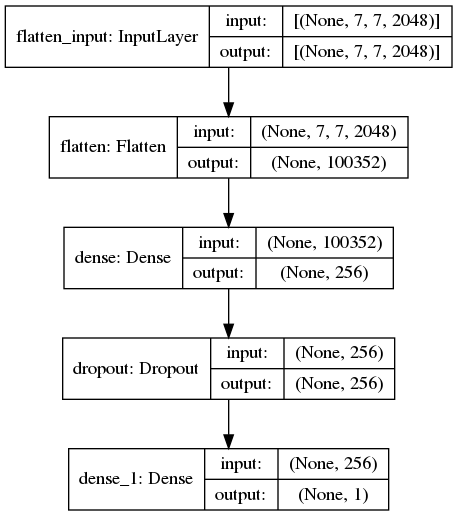

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [28]:
model.save('/home/sergey/maga_diploma/models/classif_text_img/class_text_image_resnet_ideal_last_version_last.h5')

In [2]:
from keras.models import load_model
model = load_model('/home/sergey/maga_diploma/models/classif_text_img/class_text_image_resnet.h5')

## Здесь лучший результат

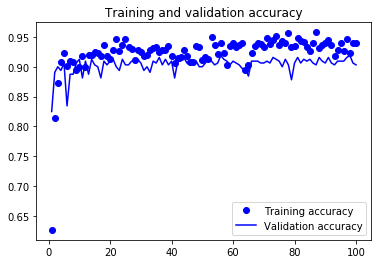

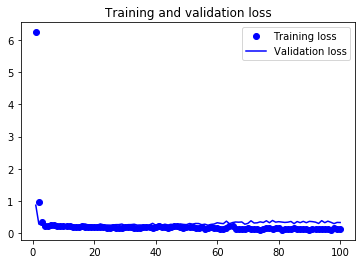

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ========

In [11]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice(['/media/sergey/Transcend/Serega/maga_diplom/common/images'])#([base_dir+'one_pict_sign', base_dir+'text_color_dark_backgr'])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*2048))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Image')
        else:
            print('Text')

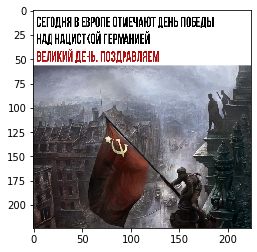

Image


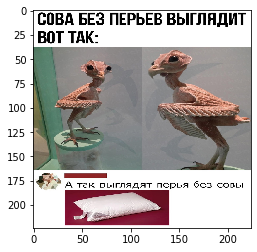

Image


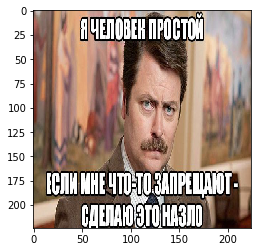

Image


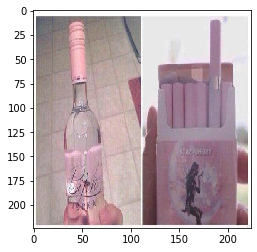

Image


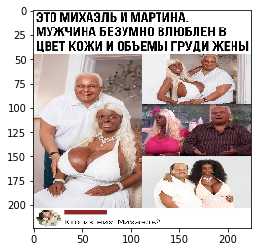

Image


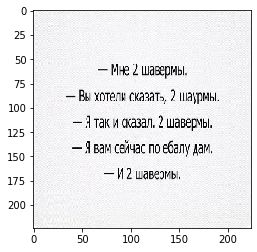

Text


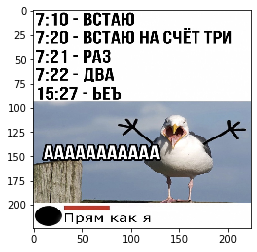

Image


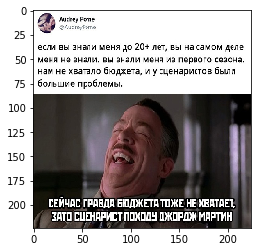

Image


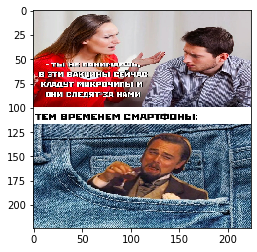

Image


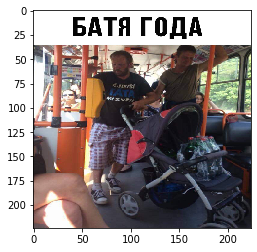

Image


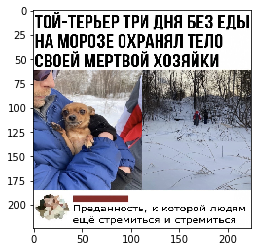

Image


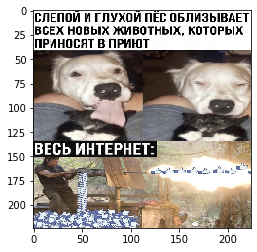

Image


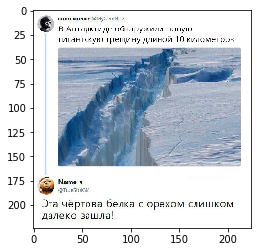

Image


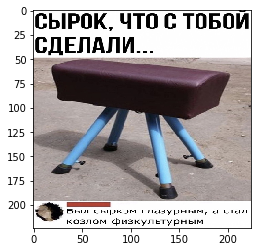

Image


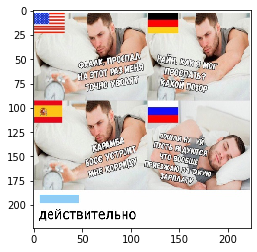

Image


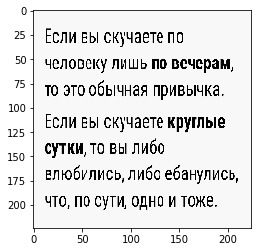

Text


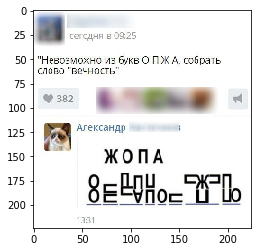

Image


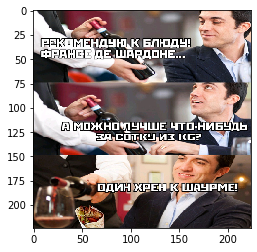

Image


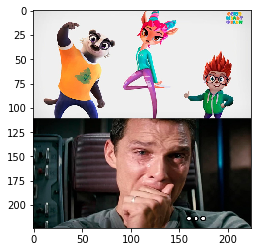

Image


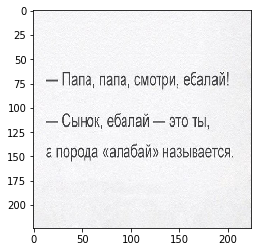

Text


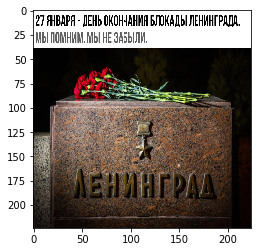

Image


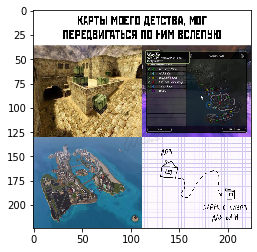

Image


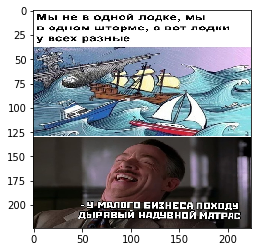

Image


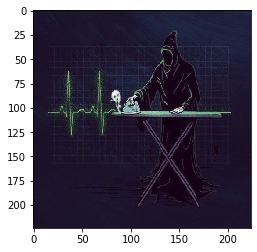

Image


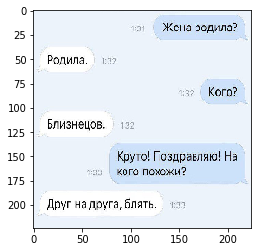

Text


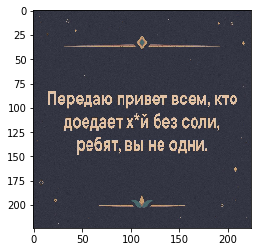

Text


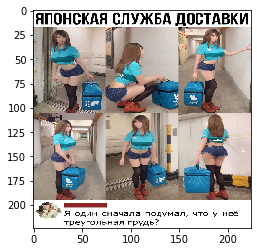

Image


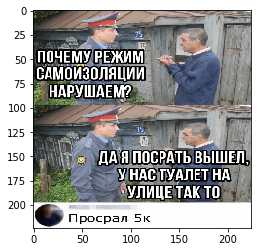

Text


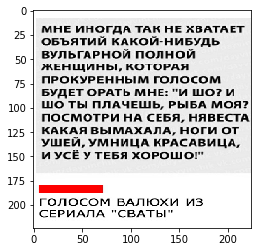

Text


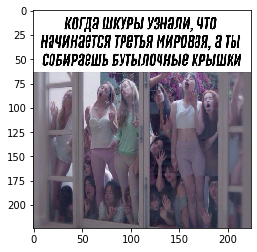

Image


In [27]:
visualize_predictions(model, 30)

## DF: field 'type'

In [10]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import date, datetime as dt
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [7]:
path_to_tsv_files = ! ls ../../communities/*/*.tsv

In [1]:
tsv_files = ! ls ../../communities/*/*.tsv | xargs -n1 basename

In [8]:
owner_ids = [filename.split('_')[1] for filename in tsv_files]

In [5]:
name_dirs = [filename.rsplit('_', 2)[0] for filename in tsv_files]

In [6]:
owner_ids

['-91050183', '-28468381', '-25679656']

In [4]:
tsv_files

['4ch_-95355317_20220512_180137.tsv',
 'dayvinchik_-91050183_20220521_012411.tsv',
 'jokesss_-28468381_20220521_004303.tsv',
 'mudakoff_-57846937_20220512_192721.tsv',
 'sarsar_-25679656_20220521_023555.tsv',
 'scolu_-158490202_20220512_173558.tsv',
 'weirdreparametrizationtrick_-131489096_20220512_171620.tsv']

In [8]:
name_dirs

['dayvinchik_-91050183', 'jokesss_-28468381', 'sarsar_-25679656']

In [9]:
dfs = []
for i in range(len(path_to_tsv_files)):
    df = pd.read_csv(path_to_tsv_files[i], sep='\t')
    del df['Unnamed: 0']
    df.insert(0, 'id_community', owner_ids[i])
    dfs.append(df)
    
df = pd.concat(dfs, ignore_index=True)
df.rename(columns = {'id':'id_post', 'text':'text_post', 'url':'image_url'}, inplace = True)
df['type_post'] = np.nan

In [12]:
df_proba = df.copy()

In [167]:
df_proba.head()

id_community  id_post          date_posted  count_likes  count_views  \
0    -95355317  2106072  2022-05-12 16:03:00           27       2956.0   
1    -95355317  2106041  2022-05-12 12:03:02            6       6342.0   
2    -95355317  2106036  2022-05-12 11:03:00           42       5472.0   
3    -95355317  2106029  2022-05-12 10:03:00            9       8934.0   
4    -95355317  2105985  2022-05-11 20:10:00           50       5973.0   

   count_comments  count_reposts text_post  \
0               0             29    "Двач"   
1               4              9    "Двач"   
2               7              8    "Двач"   
3               7              5    "Двач"   
4               2             33    "Двач"   

                                           image_url  \
0  https://sun1-23.userapi.com/s/v1/ig2/MdXWO9Vs1...   
1  https://sun1-18.userapi.com/s/v1/ig2/gwRD8wNJH...   
2  https://sun1-57.userapi.com/s/v1/ig2/8uYDHCNDZ...   
3  https://sun1-55.userapi.com/s/v1/ig2/iyfPNRSKA...   
4  https://sun1-21.userapi.com/s/v1/ig2/gtlbA9oBj...   

                               post_url  type_post  
0  https://vk.com/wall-95355317_2106072        NaN  
1  https://vk.com/wall-95355317_2106041        NaN  
2  https://vk.com/wall-95355317_2106036        NaN  
3  https://vk.com/wall-95355317_2106029        NaN  
4  https://vk.com/wall-95355317_2105985        NaN

In [13]:
from tensorflow.keras.applications import ResNet50
from keras.models import load_model

model = load_model('/home/sergey/maga_diploma/models/classif_text_img/class_text_image_resnet_ideal_last_version_last.h5')

img_width, img_height = 224, 224
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [15]:
all_path_images = ! for f in ../../communities/*/images/*; do echo "$f"; done

In [19]:
def predict_type_post(classifier, path_to_images, my_df):
    now_time = str(dt.now())
    cnt = 0
    for img_path in tqdm(path_to_images):
        try:
            cnt += 1
            owner_id = img_path.split(os.sep)[-1].split('_')[1]
            id_post = img_path.split(os.sep)[-1].split('_')[-1].split('.')[0]

            # Get picture
            img = image.load_img(img_path, target_size=(img_width, img_height))
            img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
            img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

            # Extract features
            features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

            # Make prediction
            try:
                prediction = classifier.predict(features)
            except:
                prediction = classifier.predict(features.reshape(1, 7*7*2048))

            # Write prediction
            if prediction < 0.5: #Image
                mytype = 'image'
            else: #Text
                mytype = 'text'
            my_df.loc[(my_df['id_community'] == owner_id) & (my_df['id_post'] == int(id_post)), ['type_post']] = mytype
            if cnt%5000 == 0:
                my_df.to_csv(f'dataset_social_{now_time}_2.tsv', sep='\t')
        except:
            print(img_path)
    my_df.to_csv(f'dataset_social_{now_time}_2.tsv', sep='\t')
    return my_df

In [20]:
res_df = predict_type_post(model, all_path_images, df_proba)

  1%|          | 735/113176 [00:54<2:11:18, 14.27it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_11154940.jpg


  1%|          | 872/113176 [01:04<2:00:53, 15.48it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_11325349.jpg


  5%|▍         | 5105/113176 [06:32<2:05:15, 14.38it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_21016287.jpg


  5%|▌         | 6208/113176 [08:01<2:06:03, 14.14it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_21985341.jpg


  6%|▌         | 6587/113176 [08:32<2:00:16, 14.77it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_22231815.jpg


  7%|▋         | 8290/113176 [10:48<2:01:11, 14.42it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_24016563.jpg


  7%|▋         | 8443/113176 [11:01<2:07:07, 13.73it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_24112637.jpg


  8%|▊         | 8749/113176 [11:26<2:24:19, 12.06it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_24318157.jpg


  8%|▊         | 9028/113176 [11:48<2:02:46, 14.14it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_24539359.jpg


  8%|▊         | 9161/113176 [11:59<2:00:08, 14.43it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_24628762.jpg


  9%|▊         | 9716/113176 [12:45<2:08:52, 13.38it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_24976094.jpg


  9%|▉         | 10427/113176 [13:44<1:54:39, 14.93it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_25351034.jpg
../../communities/dayvinchik/images/dayvinchik_-91050183_25353364.jpg


  9%|▉         | 10687/113176 [14:05<2:05:20, 13.63it/s]

../../communities/dayvinchik/images/dayvinchik_-91050183_25549303.jpg


 61%|██████    | 69106/113176 [1:29:07<48:25, 15.17it/s]  

../../communities/sarsar/images/sarsar_-25679656_1281367.jpg


 62%|██████▏   | 69871/113176 [1:30:06<44:16, 16.30it/s]  

../../communities/sarsar/images/sarsar_-25679656_1318604.jpg


 62%|██████▏   | 70016/113176 [1:30:17<52:42, 13.65it/s]  

../../communities/sarsar/images/sarsar_-25679656_1324460.jpg


 62%|██████▏   | 70551/113176 [1:30:56<44:23, 16.00it/s]  

../../communities/sarsar/images/sarsar_-25679656_1340961.jpg


100%|██████████| 113176/113176 [2:24:10<00:00, 13.08it/s] 


In [21]:
res_df.shape

(113186, 11)

In [26]:
res_df[res_df['type_post'].isnull()]

id_community   id_post       date_posted  count_likes  count_views  \
287       -91050183  25549303    5/3/2022 20:18        13282     748738.0   
506       -91050183  25353364   4/19/2022 20:01         4625     348829.0   
509       -91050183  25351034   4/19/2022 14:11         9650     568352.0   
1150      -91050183  24976094    3/12/2022 9:11        14318     536635.0   
1660      -91050183  24628762     2/7/2022 7:01         5977     705740.0   
1782      -91050183  24539359   1/30/2022 12:41        10229     455951.0   
2035      -91050183  24318157   1/13/2022 10:11        14174     979298.0   
2317      -91050183  24112637  12/26/2021 22:01         5480     645138.0   
2445      -91050183  24016563  12/17/2021 15:41         7146     514554.0   
3796      -91050183  22231815     8/2/2021 3:31         8806     783783.0   
4100      -91050183  21985341    7/14/2021 1:11        20183     491001.0   
4836      -91050183  21016287   5/29/2021 15:47        39420    1281613.0   
5716      -91050183  11325349   3/21/2020 11:23       119181    1044119.0   
5783      -91050183  11154940   3/16/2020 18:31        53171     718707.0   
56715     -25679656   1340961    3/30/2022 3:45         2367      89497.0   
57194     -25679656   1324460   2/25/2022 19:45         1195      68687.0   
57314     -25679656   1318604   2/17/2022 10:45         4827     134533.0   
57987     -25679656   1281367    1/6/2022 11:45         1173      54306.0   
59193     -25679656   1222429   10/31/2021 6:45         1156      68186.0   
59310     -25679656   1217192   10/25/2021 1:45         1390      65209.0   
60417     -25679656   1172002   8/25/2021 11:45         5390     178299.0   
61367     -25679656   1134109    7/4/2021 17:45          505      42820.0   
65535     -25679656    934822   11/4/2020 16:05         3777     146119.0   
67778     -25679656    818604   6/24/2020 12:45         3324     173544.0   
101965    -25679656     31664    8/9/2014 21:40         2740          NaN   
106595    -25679656     23060     1/4/2014 2:40         3385          NaN   

        count_comments  count_reposts  \
287                466            126   
506                 66             64   
509                124            209   
1150               194            165   
1660               135             65   
1782               108            254   
2035               375            354   
2317               407           1116   
2445               193            172   
3796               100            265   
4100               281            882   
4836               534           2104   
5716                 0            185   
5783                 0             91   
56715               76            640   
57194               28            798   
57314              108           3450   
57987               48            263   
59193               12            517   
59310               11            774   
60417               76           2053   
61367                8            174   
65535               19             45   
67778              440             97   
101965               0            261   
106595               0            530   

                                       text_post  \
287        Сегодня Иде Галич исполнилось 32 года   
506                                          NaN   
509       Алишер Тагирович пытается бросить пить   
1150                                         NaN   
1660                            Лучшие сестрички   
1782                                         NaN   
2035    Родила 5-ых и сохранила идеальную фигуру   
2317                                   До слез..   
2445                                         NaN   
3796                                         NaN   
4100                                         NaN   
4836                                         NaN   
5716                                         NaN   
5783                                         NaN   
56715                                  

In [242]:
res_df.tail()

id_community  id_post          date_posted  count_likes  count_views  \
89139   -131489096        8  2016-10-25 13:45:43           93          NaN   
89140   -131489096        5  2016-10-24 21:59:48           59          NaN   
89141   -131489096        4  2016-10-24 21:48:42            5          NaN   
89142   -131489096        2  2016-10-24 21:44:34           60          NaN   
89143   -131489096        1  2016-10-24 21:42:52           38          NaN   

       count_comments  count_reposts  \
89139               0              5   
89140               4              0   
89141               0              0   
89142               0              3   
89143               0              2   

                                               text_post  \
89139                                                NaN   
89140  Однажды студент решил доебаться до Воронцова и...   
89141                                                NaN   
89142                                                NaN   
89143                                                NaN   

                                               image_url  \
89139  https://sun9-77.userapi.com/s/v1/if1/duF-Cfz49...   
89140  https://sun9-35.userapi.com/s/v1/if1/HGrSIBju3...   
89141  https://sun9-4.userapi.com/s/v1/if1/5Kxn7ywZeh...   
89142  https://sun9-59.userapi.com/s/v1/if1/Yd7-1HzBT...   
89143  https://sun9-72.userapi.com/s/v1/if1/O9Uzc3mNF...   

                              post_url type_post  
89139  https://vk.com/wall-131489096_8     image  
89140  https://vk.com/wall-131489096_5     image  
89141  https://vk.com/wall-131489096_4      text  
89142  https://vk.com/wall-131489096_2     image  
89143  https://vk.com/wall-131489096_1     image

In [27]:
res_df.to_pickle("./dataset_social_2.pkl") 

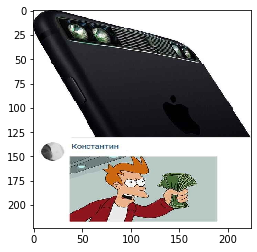

Image


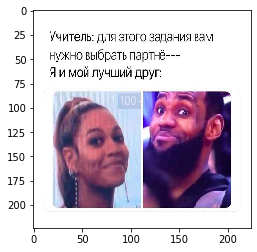

Image


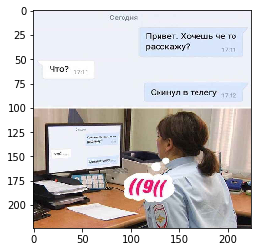

Image


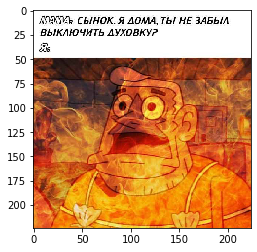

Image


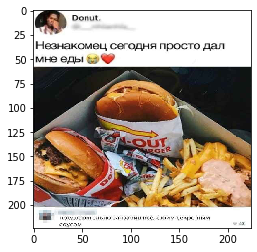

Image


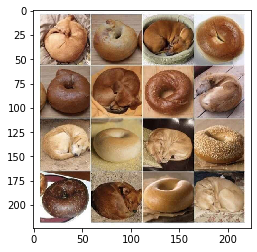

Image


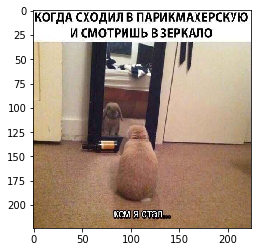

Image


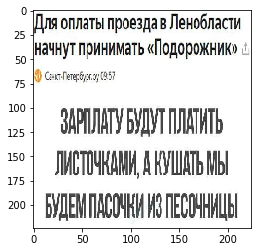

Text


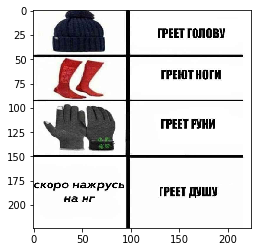

Image


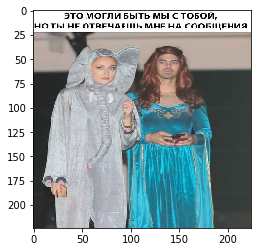

Image


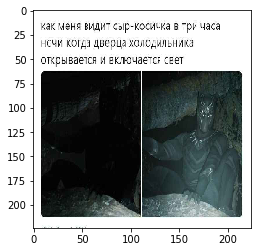

Image


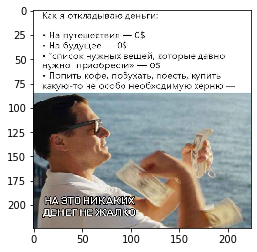

Image


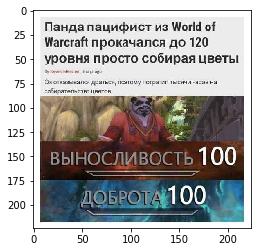

Image


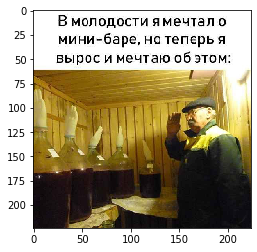

Image


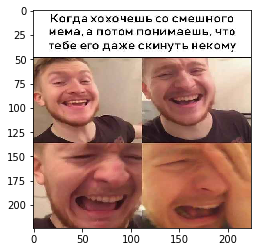

Image


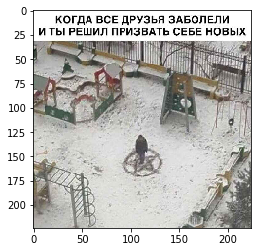

Image


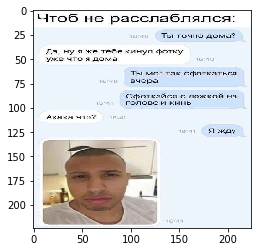

Image


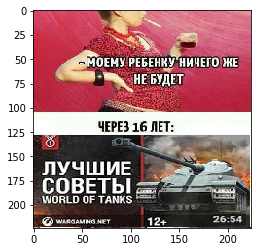

Text


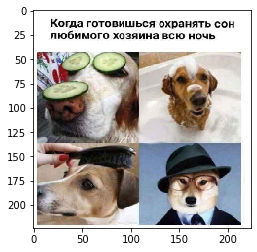

Image


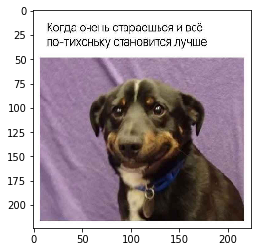

Image


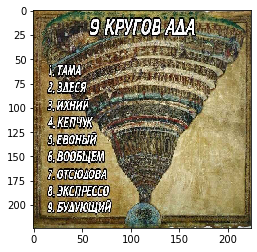

Image


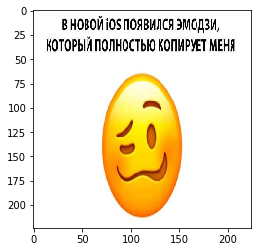

Image


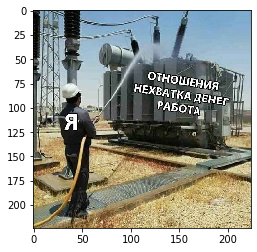

Image


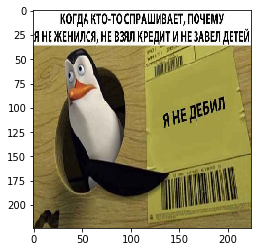

Image


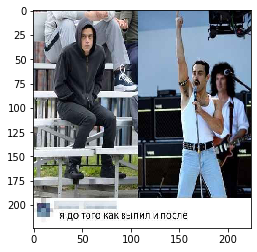

Image


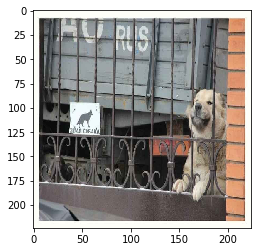

Image


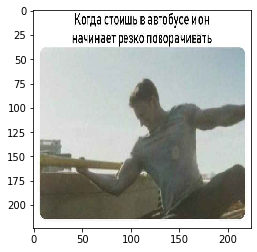

Image


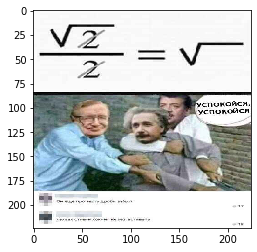

Image


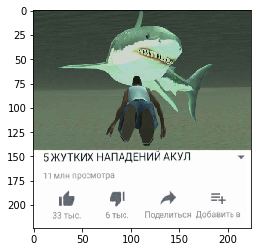

Image


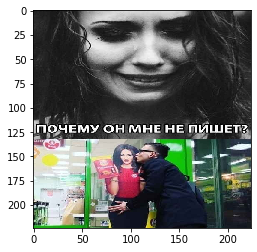

Image


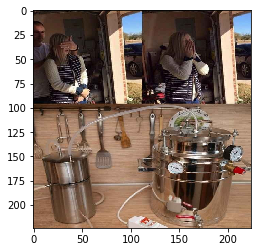

Image


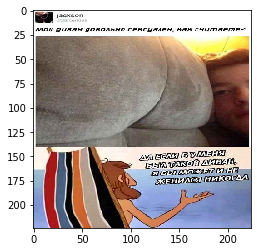

Image


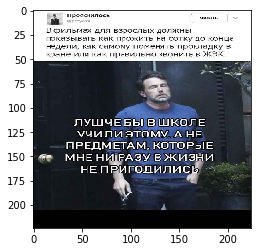

Image


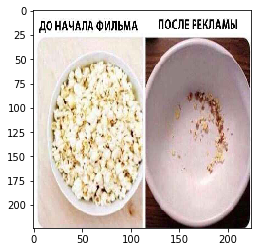

Image


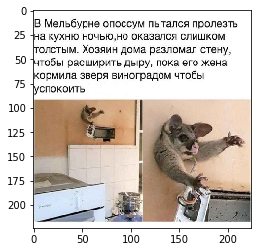

Image


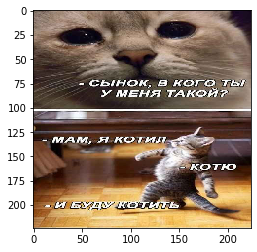

Image


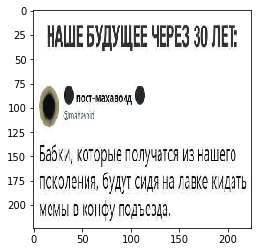

Image


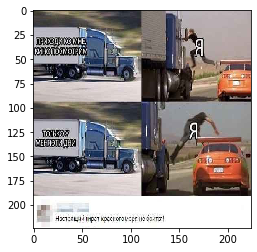

Image


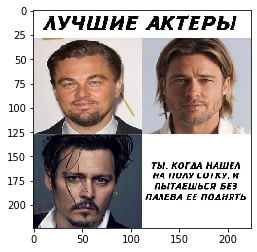

Image


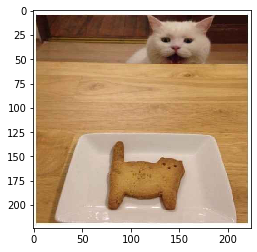

Image


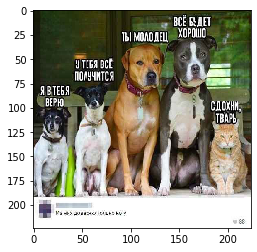

Image


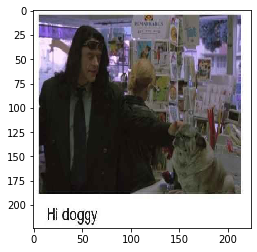

Image


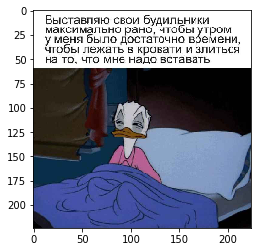

Image


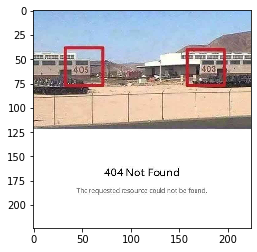

Text


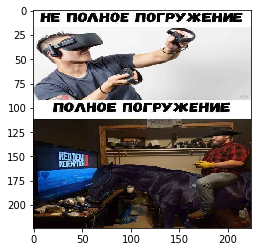

Image


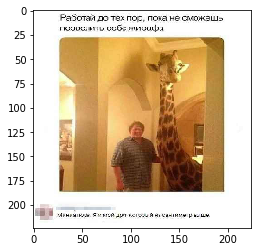

Image


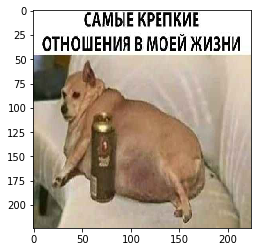

Image


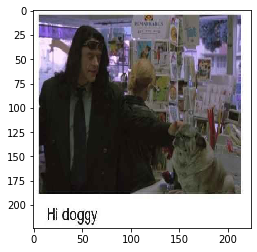

Image


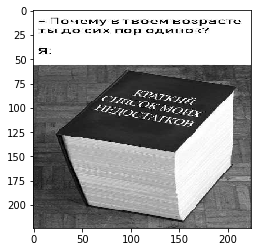

Image


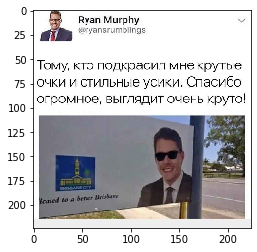

Image


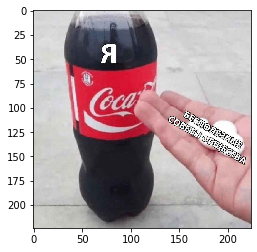

Image


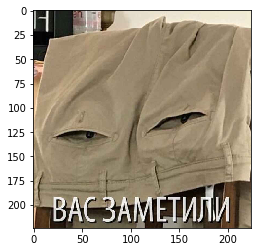

Image


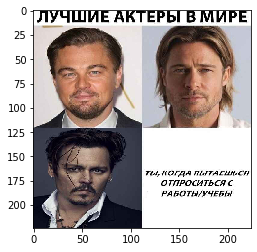

Image


KeyboardInterrupt: 

In [151]:
visualize_predictions(model, all_path_images, df)